<a href="https://colab.research.google.com/github/dunliangyang2010/Generative-Deep-Learning/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import backend as K
from keras.datasets import mnist
from tensorflow.keras.utils import plot_model

## Load data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# (x_train.shape) = (60000, 28, 28)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]) ))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]) ))
print(x_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784)


## Define data distribution
parameters:  
`mean`: 分配平均數的點  
`log_sigma`: 各維度變異數的對數 
***  
encoder會將輸入影像編為兩向量:`mean`,`log_sigma`,兩參數就可在一空間內定義一個多元常態分布  
***  
欲將某影像編碼於空間中的特定點z,即在此分布中抽樣的方法:  
$ z=mean+sigma*epsilon $  
其中  
$ sigma=exp(log__sigma/2) $  
`epsilon`表示抽樣自此常態分布中的某點,`sigma`可看成信心指數  



In [ ]:
# 將28x28投影至2維空間,但非直接投影,而是考慮每個點的分布,並從中取樣

original_dim = 28*28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim, ))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)

z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [ ]:
# K.shape(z_mean) # <KerasTensor: shape=(2,) dtype=int32 inferred_value=[None, 2] (created by layer 'tf.compat.v1.shape')>

# K.shape(z_mean)[0] inferred_value=[None]

# epsilon >> [None, latent_dim]

<KerasTensor: shape=() dtype=int32 inferred_value=[None] (created by layer 'tf.__operators__.getitem_5')>

In [ ]:
def sampling(args):
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), # 初始化tensor
                mean=0, stddev=0.1
                ) 
  sigma = K.exp(z_log_sigma)
  
  return z_mean + sigma * epsilon

# Lambda layer可將各函式包成一個keras layer
z = layers.Lambda(sampling)([z_mean, z_log_sigma])

## Model construct

In [ ]:
# encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# decoder
latent_inputs = keras.Input(shape=(latent_dim, ), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# VAE model
outputs = decoder(encoder(inputs)[2]) # encoder輸出3種,最後一個z才是代表取樣點
vae = keras.Model(inputs, outputs, name='vae_mlp')

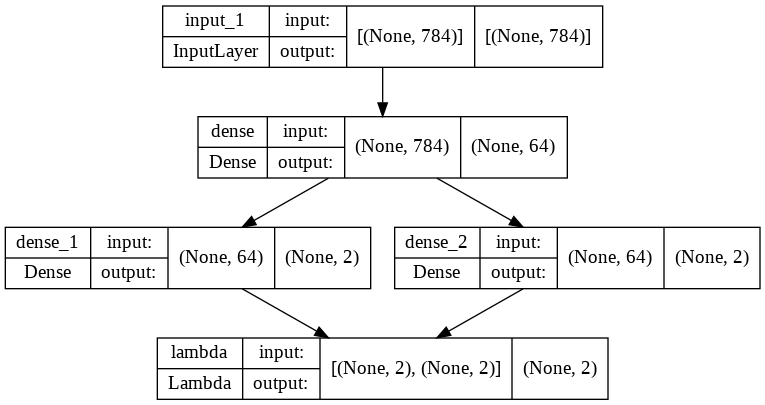

In [ ]:
# encoder
from tensorflow.keras.utils import plot_model
plot_model(encoder, show_shapes='True')

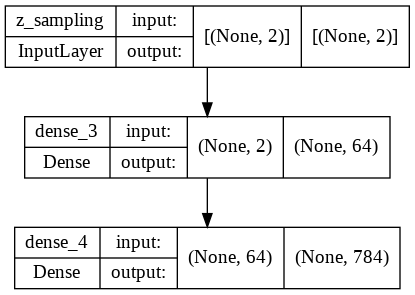

In [ ]:
# decoder
plot_model(decoder, show_shapes='True')

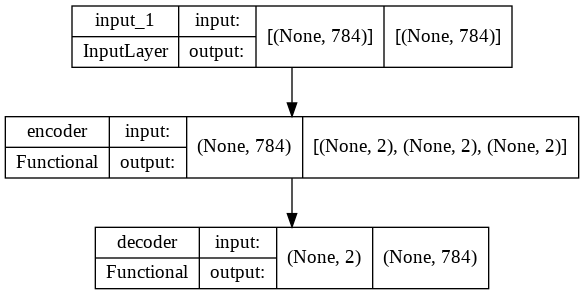

In [ ]:
# vae
plot_model(vae, show_shapes='True')

## Custom loss
VAE中,因考量資料機率分布,    
故Loss為 重構損失(RMSE,Cross-entropy) 與 分布損失(KL) 的總和  
==>  
Loss = `factor`*`Reconstruction_loss` + `KL_loss`   
***
散度Kullback-Leibler(KL): 衡量A機率分布與另個B機率分布的差異程度  
於此例即是衡量模型分布(自訂mean,log_sigma)與常態分布的差異  
***
```kl_loss = -0.5*sum(1+log_sigma - mean^2 - exp(log_sigma))```  
故當`mean`及`log_sigma`皆為0,此時KL最小; 反之不為0則增加

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim # 推測乘原始資料長度原因為,與kl_loss(整體分布)做匹配,將單個重構損失變為整體重構損失

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss) # keras官方以平均作為最後總損失

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
# 另一寫法(有錯待改!!)

def vae_r_loss(y_true, y_pred):
  r_loss = keras.losses.binary_crossentropy(inputs, outputs)
  r_loss *= original_dim
  return r_loss

def vae_kl_loss(y_true, y_pred):
  kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  return kl_loss

def vae_loss(y_true, y_pred):
  r_loss = vae_r_loss(y_true, y_pred)
  kl_loss = vae_kl_loss(y_true, y_pred)
  return K.mean(r_loss + kl_loss)

# compile
vae.compile(optimizer='adam', loss=vae_loss)

# Training

In [ ]:
vae.fit(x_train, x_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_test, x_test))

Epoch 1/50
1875/1875 [==============================] - 6s 3ms/step - loss: 336.0648 - val_loss: 329.3568
Epoch 2/50
1654/1875 [=========================>....] - ETA: 0s - loss: 326.6425

KeyboardInterrupt: ignored